In [1]:
import torch
import pickle
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [2]:
# dump_file = "../data/processed/sbert_embeddings.dat"
# with open(dump_file, "rb") as f:
#     embeddings = pickle.load(f)

# print(embeddings.shape)

In [3]:
## read in the dataset
df = pd.read_csv("../data/stimuli_idioms_clean.csv")
# dataset = df[["item"]]
# norm_freq_en = df["fitem"]

# get the previously calculated embeddings from the file in which they were stored
# requires running run_one_experiment.py or run_all_experiments.py first
embeddings_cache_filename = "../data/processed/sbert_stimuli_idioms_clean-last_1-kwics-concat.dat"
with open(embeddings_cache_filename, "rb") as colloc2BERTfile:
    colloc_embeddings = pickle.load(colloc2BERTfile)

In [4]:
collocs = list(colloc_embeddings.keys())
embeddings = torch.stack([colloc_embeddings[colloc]["vec"] for colloc in collocs])

# norm embeddings (same as in run_one_experiment.py)
embeddings = (embeddings - embeddings.mean()) / embeddings.std()

print(embeddings.shape)
colloc_embeddings = pd.DataFrame(
    {
        "item": collocs,
        "vec": embeddings.tolist(),
    }
)
colloc_embeddings

torch.Size([246, 768])


,item,vec
0,abandon ship,"[0.6813992857933044, 0.6821767687797546, 2.079..."
1,battle demon,"[0.28214821219444275, 0.708100438117981, 0.367..."
2,beat drum,"[1.1023974418640137, 0.3866420090198517, 1.302..."
3,bend knee,"[0.0939703956246376, 1.617830753326416, -1.054..."
4,blow smoke,"[1.4555710554122925, 0.6088924407958984, 1.256..."
...,...,...
241,fuel passion,"[0.11440841853618622, 0.43344083428382874, 0.4..."
242,fan fear,"[0.5318445563316345, 0.07368212193250656, 0.18..."
243,sweeten deal,"[-0.12492208182811737, 0.14423401653766632, 0...."
244,close case,"[0.5094650387763977, 0.1782718300819397, 0.642..."


In [5]:
df_expanded = df.merge(colloc_embeddings, on="item")
df_expanded

,item,fitem,score,type,verb,noun,stimuli_grammatical,stimuli_plural,vec
0,abandon ship,16629,7.9,idiom,abandon,ship,abandon ship,abandon ship,"[0.6813992857933044, 0.6821767687797546, 2.079..."
1,abandon building,15935,7.2,prod,abandon,building,abandon building,abandon buildings,"[0.6555113792419434, 0.733307421207428, 0.8596..."
2,abandon plan,19302,6.7,collocation,abandon,plan,abandon the plan,abandon plans,"[0.8033574223518372, 0.8661871552467346, 1.792..."
3,battle demon,4244,8.0,idiom,battle,demon,battle one's demons,battle demons,"[0.28214821219444275, 0.708100438117981, 0.367..."
4,battle enemy,3316,6.4,prod,battle,enemy,battle the enemy,battle enemies,"[0.41101789474487305, 0.6878573894500732, 0.11..."
...,...,...,...,...,...,...,...,...,...
241,unlock car,5734,5.3,prod,unlock,car,unlock the car,unlock cars,"[-1.069042682647705, 0.49273478984832764, -0.1..."
242,unlock potential,27122,8.5,collocation,unlock,potential,unlock potential,unlock potential,"[-0.46213677525520325, 0.435224324464798, 0.00..."
243,weave web,6389,7.9,idiom,weave,web,weave a web,weave webs,"[-0.04823963716626167, -0.14014706015586853, 0..."
244,weave basket,7588,8.5,prod,weave,basket,weave a basket,weave baskets,"[0.5938814878463745, 0.4889236092567444, 0.583..."


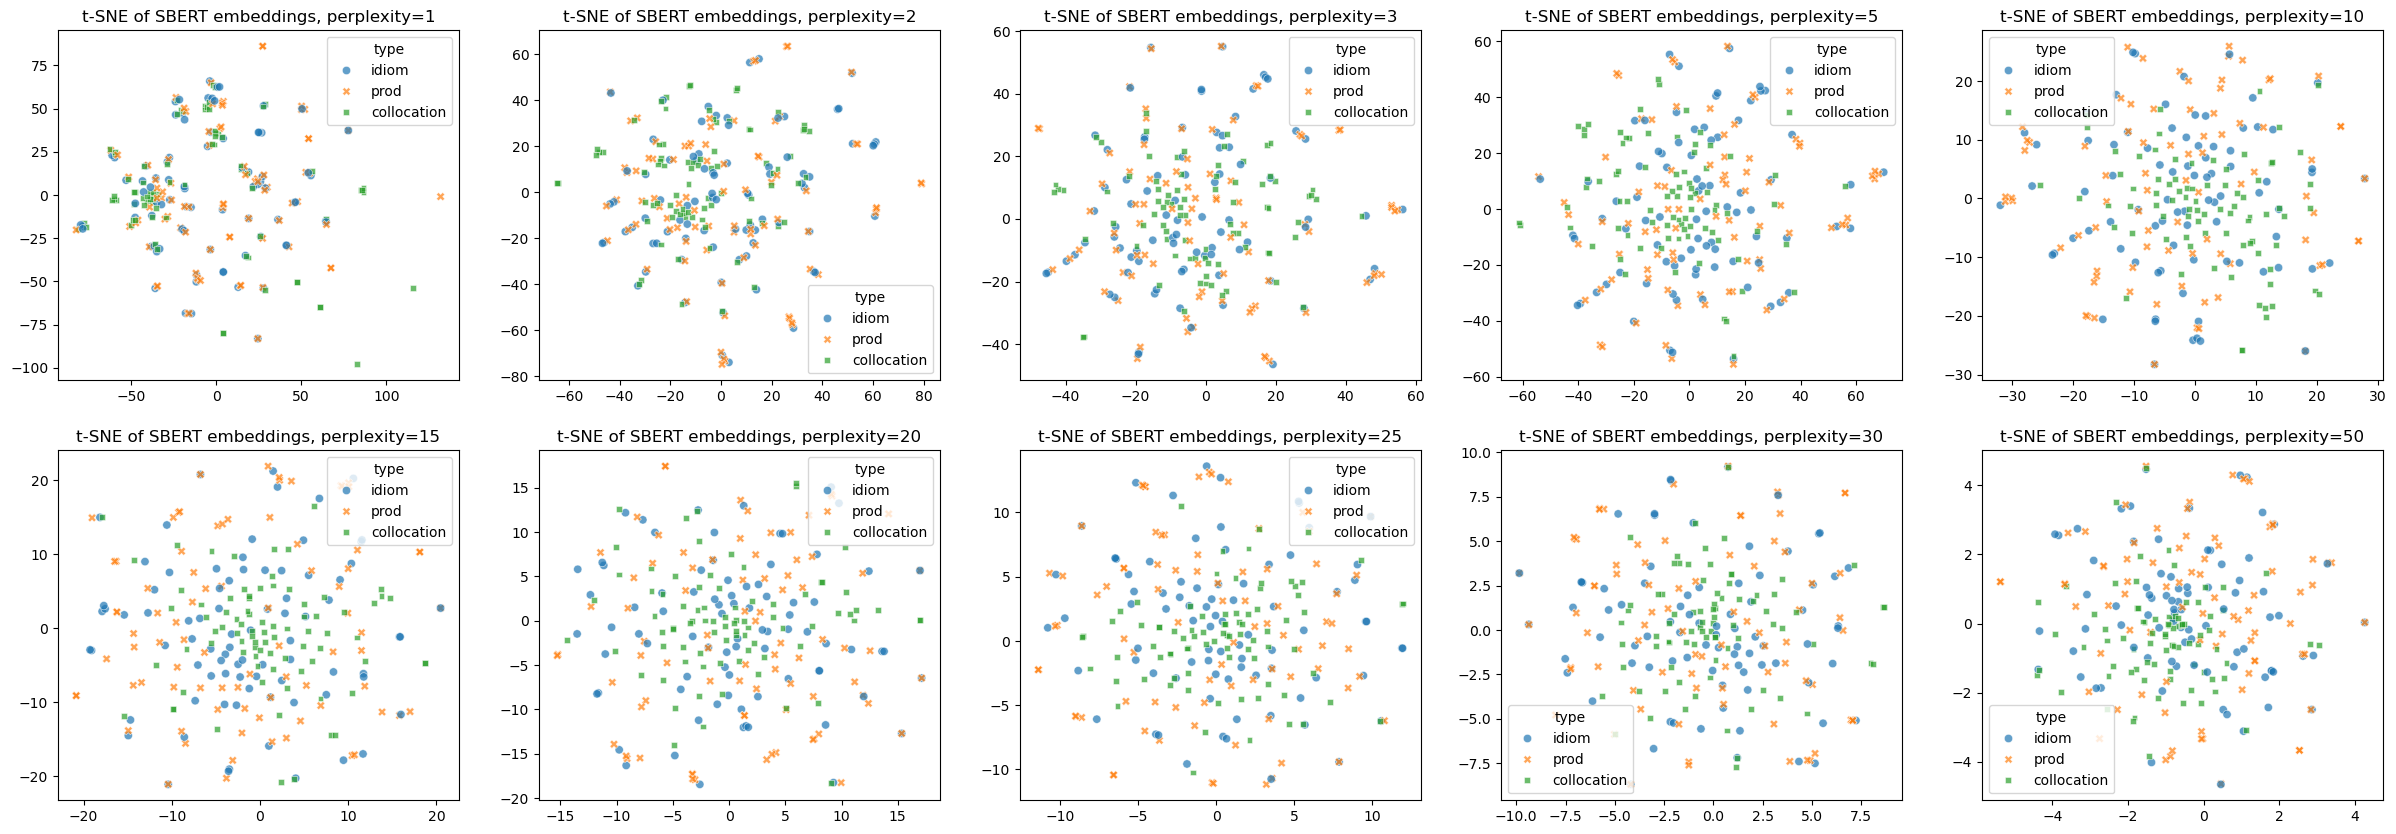

In [6]:
## TSNE of embeddings, colored by item type
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

# iterate over different perplexity values
fig, axes = plt.subplots(2, 5, figsize=(30, 10))

for i, (perplexity, ax) in enumerate(zip([1,2,3,5,10,15,20,25,30,50], axes.flatten())):
    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
    embeddings_2d = tsne.fit_transform(np.array(df_expanded["vec"].tolist()))
    ax.set_title(f"t-SNE of SBERT embeddings, perplexity={perplexity}")
    sns.scatterplot(
        x=embeddings_2d[:, 0],
        y=embeddings_2d[:, 1],
        data=df_expanded,
        hue="type",
        style="type",
        # palette=sns.color_palette("hls", 10),
        legend="full",
        alpha=0.7,
        ax=ax,
    )


# tsne = TSNE(n_components=2, random_state=0, perplexity=5)
# embeddings_2d = tsne.fit_transform(np.array(df_expanded["vec"].tolist()))

# plot with seaborn
# fig, ax = plt.subplots()
# ax.set_title("t-SNE of SBERT embeddings, colored by item type")
# sns.scatterplot(
#     x=embeddings_2d[:, 0],
#     y=embeddings_2d[:, 1],
#     data=df_expanded,
#     hue="type",
#     style="type",
#     # palette=sns.color_palette("hls", 10),
#     legend="full",
#     alpha=0.7,
#     ax=ax,
# )

<Axes: title={'center': 'ICA of SBERT embeddings, colored by item type'}>

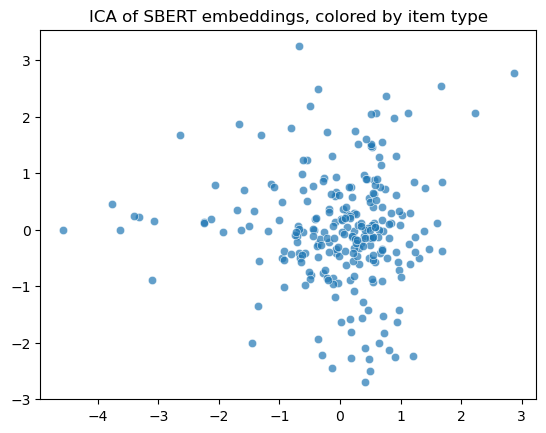

In [7]:
## TSNE of embeddings, colored by item type
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA

ica = FastICA(n_components=2, random_state=0)
embeddings_2d = ica.fit_transform(np.array(df_expanded["vec"].tolist()))

# plot with seaborn
fig, ax = plt.subplots()
ax.set_title("ICA of SBERT embeddings, colored by item type")
sns.scatterplot(
    x=embeddings_2d[:,0], y=embeddings_2d[:,1],
    # palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.7,
    ax=ax
)

/opt/homebrew/Caskroom/mambaforge/base/envs/minerva/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/mambaforge/base/envs/minerva/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/homebrew/Caskroom/mambaforge/base/envs/minerva/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/minerva/lib/python3.9/site-packages/u

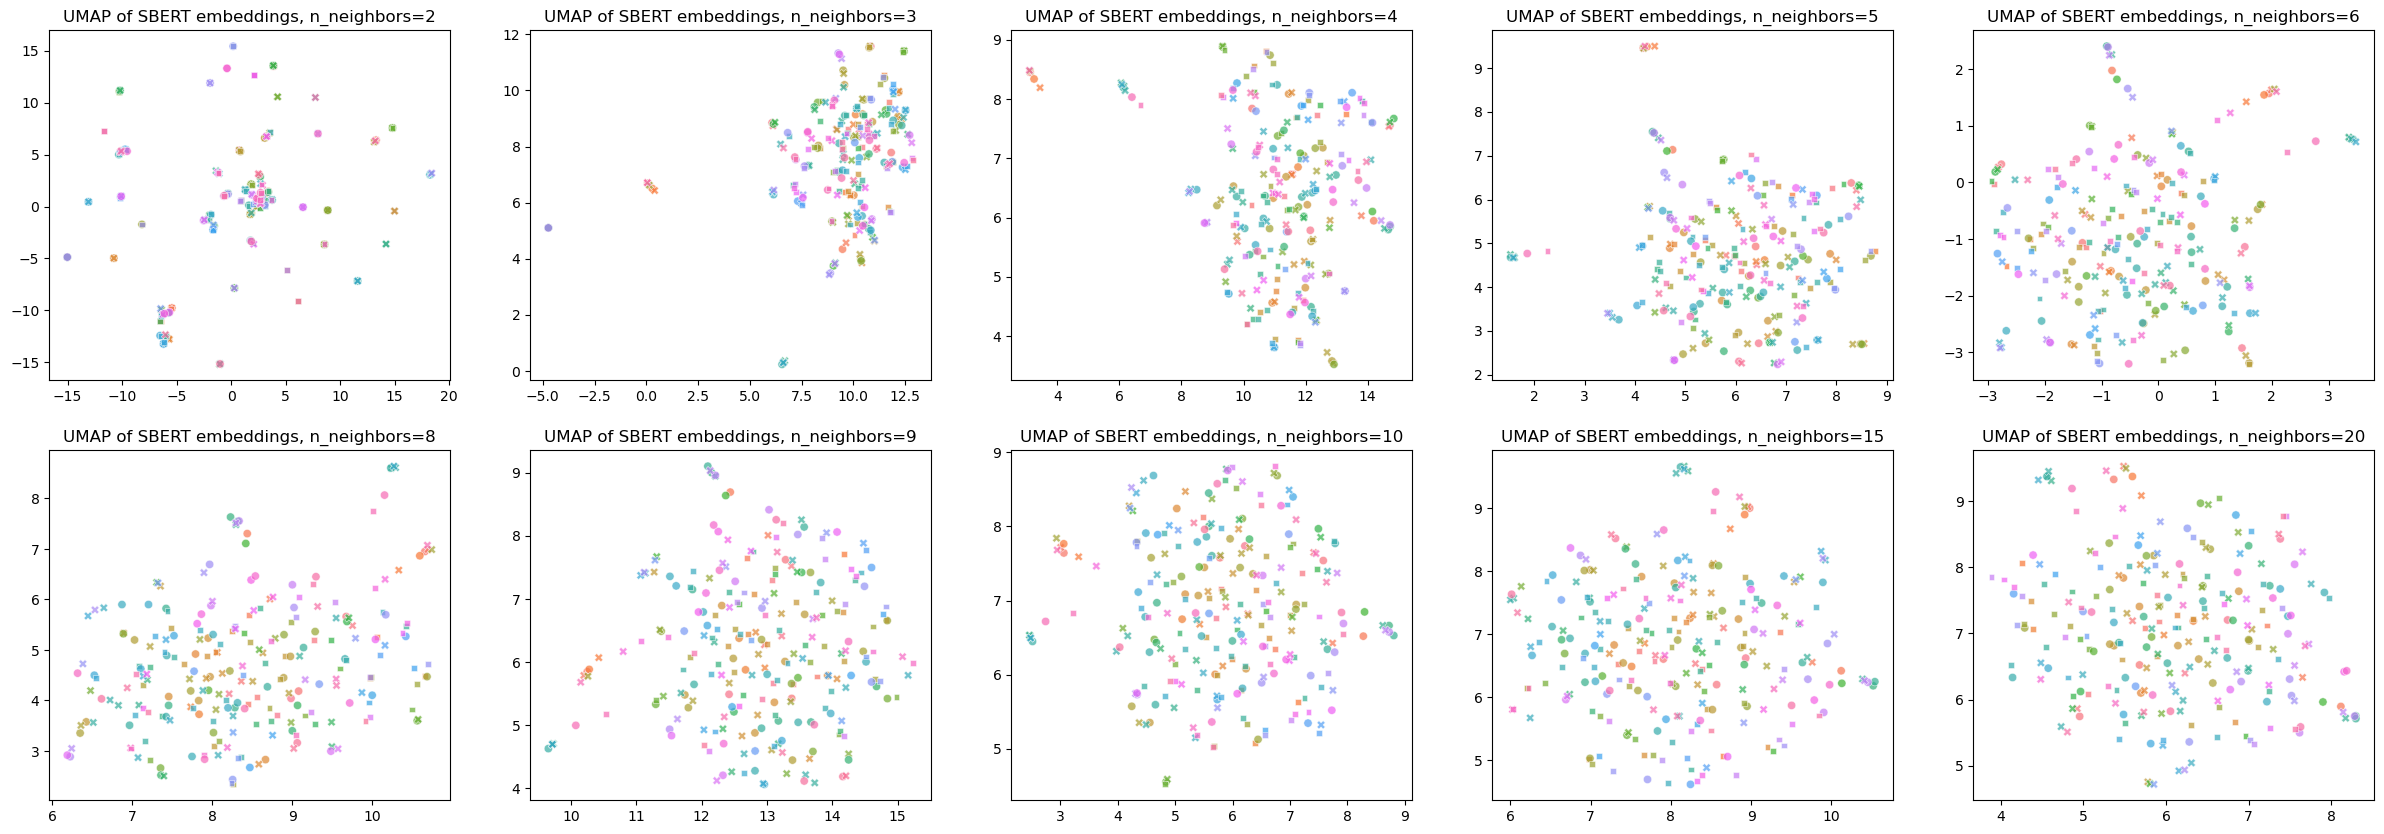

In [8]:
## UMAP of embeddings, colored by item type
import umap

# iterate over different n_neighbors values
fig, axes = plt.subplots(2, 5, figsize=(30, 10))

for i, (n_neighbors, ax) in enumerate(zip([2,3,4,5,6,8,9,10,15,20,], axes.flatten())):
    reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=0)
    embeddings_2d = reducer.fit_transform(np.array(df_expanded["vec"].tolist()))
    ax.set_title(f"UMAP of SBERT embeddings, n_neighbors={n_neighbors}")
    sns.scatterplot(
        x=embeddings_2d[:, 0],
        y=embeddings_2d[:, 1],
        data=df_expanded,
        hue="verb",
        style="type",
        # palette=sns.color_palette("hls", 10),
        legend=False,
        alpha=0.7,
        ax=ax,
    )


In [9]:
def get_sampled_matrix(embeddings, frequencies, M=10000, forget_prob=0.6, seed=None):
    assert embeddings.size(0) == len(frequencies)
    n_items, embed_dim = embeddings.shape
    # print(f"\nSeed {s}\n")
    random_generator = random.Random(seed)
    torch_generator = torch.Generator().manual_seed(seed)

    # sample from the collocations to make a M x 768 matrix
    sample_k = M - len(embeddings)

    # if do_equal_frequency:
    #     sampled_collocs = torch.stack(
    #         random_generator.choices(colloc_bert_embeddings, k=sample_k)
    #     )
    # else:

    # sampled_collocs = torch.stack(
    #     random_generator.choices(embeddings, k=sample_k, weights=frequencies)
    # )

    # sample our original items once, and the rest from the distribution
    sampled_freqs = torch.cat(
        (
            torch.arange(n_items),
            torch.multinomial(frequencies, sample_k, replacement=True, generator=torch_generator),
        )
    )
    matrix = embeddings[sampled_freqs]

    # matrix = torch.concat([embeddings, sampled_collocs], dim=0)

    assert matrix.size() == (M, embed_dim), "Huh?"

    # TODO: document noise procedure
    # again, why is noising per dimension so different?
    noise_mean = torch.tensor([0.0]).expand(M, embed_dim)
    noise_std = (
        matrix.std().expand(M, embed_dim) / 2
    )  # tie noise to the std of the matrix

    print(f"Noising with std {noise_std.mean()}")
    noise_gaussian = torch.normal(noise_mean, noise_std, generator=torch_generator)
    noise_mask = torch.rand((M, embed_dim), generator=torch_generator)
    noisy_mem = torch.where(
        noise_mask < forget_prob, matrix + noise_gaussian, matrix
    )  # if the noise is less than L, then add gaussian noise, otherwise it is the original matrix
    # noisy_mem = torch.where(
    #     noise_mask < L, 0.0, matrix
    # )  # if the noise is less than L, then add gaussian noise, otherwise it is the original matrix
    return noisy_mem, sampled_freqs

In [10]:
def get_query_sims(query_vectors, matrix):
    """
    Get pairwise cosine similarities between query vectors and a matrix of vectors.
    """
    sims = [
        torch.cosine_similarity(v.unsqueeze(0), matrix, dim=-1) for v in query_vectors
    ]
    return torch.stack(sims)

def get_mean_sims(probe_matrix_sims, sampled_items, n_items):
    pairwise_agg_sims = torch.zeros(n_items, n_items)

    data = []

    for i in range(n_items):
        for j in range(n_items):
            where_j = sampled_items == j
            item_i = df_expanded.iloc[i]["item"]
            type_i = df_expanded.iloc[i]["type"]
            item_j = df_expanded.iloc[j]["item"]
            type_j = df_expanded.iloc[j]["type"]
            mean_sim = probe_matrix_sims[i, where_j].mean()

            data.append(
                {
                    "item_i": item_i,
                    "type_i": type_i,
                    "item_j": item_j,
                    "type_j": type_j,
                    "mean_sim": mean_sim.item(),
                }
            )

            pairwise_agg_sims[i, j] = mean_sim

    return pairwise_agg_sims, pd.DataFrame(data)


Noising with std 0.49989554286003113


<Axes: >

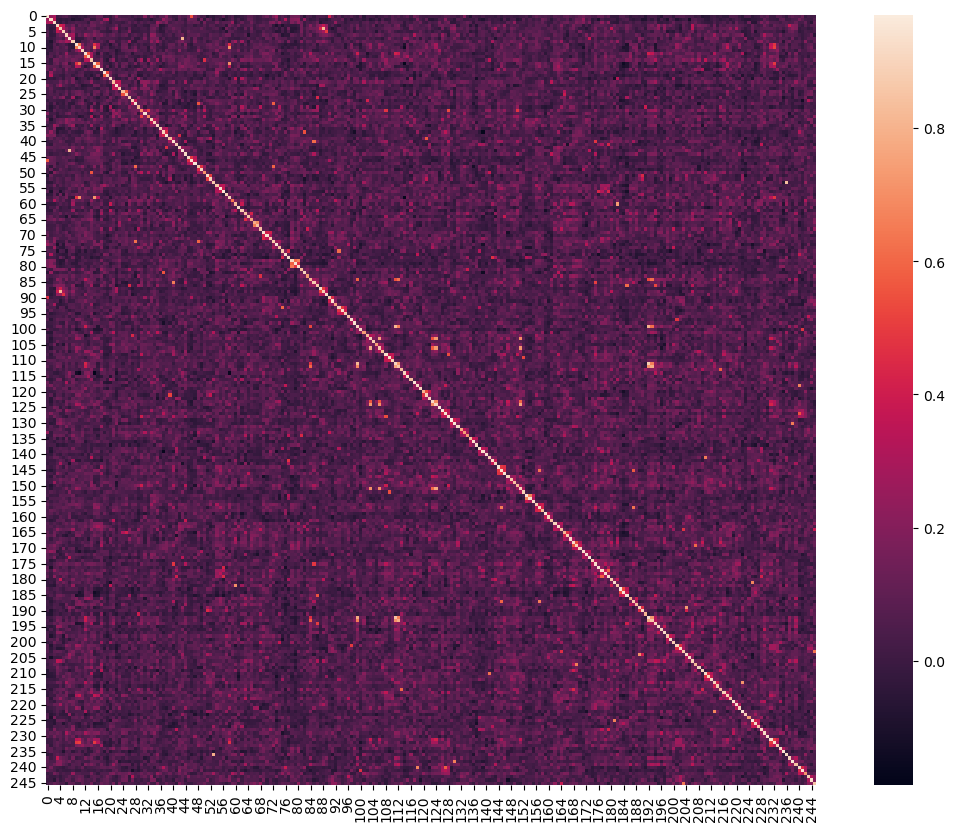

In [11]:
DO_LOG_FREQ = False

def get_minerva_matrix_and_sims(item_embeddings, item_freq, forget_prob=0.8, M=10000, seed=0):
    if DO_LOG_FREQ:
        item_freq = torch.log10(item_freq)

    sampled_matrix, sampled_items = get_sampled_matrix(
        item_embeddings,
        item_freq,
        M=M,
        forget_prob=forget_prob,
        seed=seed,
    )
    return sampled_matrix, sampled_items

item_embeddings = torch.tensor(df_expanded["vec"].tolist())
item_freq = torch.tensor(df_expanded["fitem"].tolist()).float()

sampled_matrix, sampled_items = get_minerva_matrix_and_sims(
    item_embeddings, item_freq, forget_prob=0.8, M=10000, seed=0
)
probe_matrix_sims = get_query_sims(item_embeddings, sampled_matrix)
n_items = len(item_embeddings)
pairwise_agg_sims, df_agg_sims = get_mean_sims(probe_matrix_sims, sampled_items, n_items)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(pairwise_agg_sims, ax=ax, square=True)

In [12]:
df_agg_sims

,item_i,type_i,item_j,type_j,mean_sim
0,abandon ship,idiom,abandon ship,idiom,0.948629
1,abandon ship,idiom,abandon building,prod,0.245016
2,abandon ship,idiom,abandon plan,collocation,0.285188
3,abandon ship,idiom,battle demon,idiom,-0.001203
4,abandon ship,idiom,battle enemy,prod,0.019490
...,...,...,...,...,...
60511,weave story,collocation,unlock car,prod,0.006352
60512,weave story,collocation,unlock potential,collocation,0.076545
60513,weave story,collocation,weave web,idiom,0.217091
60514,weave story,collocation,weave basket,prod,0.203586


In [13]:
# df_agg_sims.to_csv("../data/processed/sbert_stimuli_idioms_clean-last_1-kwics-concat-sims.csv", index=False)

In [14]:
# # plot mean similarity by type_i and type_j
# _sims = df_agg_sims.copy()
# # _sims["mean_sim"] = _sims["mean_sim"]
# sns.displot(
#     _sims,
#     x="mean_sim",
#     col="type_i",
#     hue="type_j",
#     kind="kde",
#     fill=True,
#     # bw_adjust=0.25,
#     # log_scale=(False, True),
# )

In [15]:
# # violin plots
# sns.violinplot(
#     data=_sims,
#     x="type_i",
#     y="mean_sim",
#     hue="type_j",
#     inner="quart",
#     linewidth=1,
# )

In [16]:
results = pd.read_csv("../results/results-stimuli_idioms_clean-300p-last_1-kwics-concat-all-fp_0.0-0.8-m2k_0.95-0.995-m2mi_300-full-sweep.csv")
results

,item,act,rt,n_kwics,id,participant,embedding_model,is_noise_embeddings,is_equal_frequency,minerva_k,minerva_max_iter,avg_last_n_layers,forget_prob
0,abandon ship,0.994109,3.0,100,6463343,1,sbert,False,False,0.950,300,1,0.0
1,battle demon,0.970299,4.0,100,6463343,1,sbert,False,False,0.950,300,1,0.0
2,beat drum,0.992235,4.0,100,6463343,1,sbert,False,False,0.950,300,1,0.0
3,bend knee,0.965434,6.0,100,6463343,1,sbert,False,False,0.950,300,1,0.0
4,blow smoke,0.967468,3.0,100,6463343,1,sbert,False,False,0.950,300,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17711995,fuel passion,0.997021,5.0,100,2305763,300,fasttext,True,True,0.995,300,1,0.8
17711996,fan fear,0.996790,5.0,100,2305763,300,fasttext,True,True,0.995,300,1,0.8
17711997,sweeten deal,0.996905,5.0,100,2305763,300,fasttext,True,True,0.995,300,1,0.8
17711998,close case,0.997271,5.0,100,2305763,300,fasttext,True,True,0.995,300,1,0.8


In [106]:
FORGET_PROB = 0.8

subset_results = results[
    (results["minerva_k"] == 0.99)
    & (results["forget_prob"] == FORGET_PROB)
    & (results["is_noise_embeddings"] == False)
    & (results["is_equal_frequency"] == True)
]
# subset_results_sbert = subset_results[subset_results["embedding_model"] == "sbert"]
# subset_results_fasttext = subset_results[
#     subset_results["embedding_model"] == "fasttext"
# ]
# subset_results_sbert
subset_results

,item,act,rt,n_kwics,id,participant,embedding_model,is_noise_embeddings,is_equal_frequency,minerva_k,minerva_max_iter,avg_last_n_layers,forget_prob
8339400,abandon ship,0.991940,3.0,100,2293522,1,sbert,False,True,0.99,300,1,0.8
8339401,battle demon,0.995924,4.0,100,2293522,1,sbert,False,True,0.99,300,1,0.8
8339402,beat drum,0.994684,4.0,100,2293522,1,sbert,False,True,0.99,300,1,0.8
8339403,bend knee,0.993610,5.0,100,2293522,1,sbert,False,True,0.99,300,1,0.8
8339404,blow smoke,0.990951,4.0,100,2293522,1,sbert,False,True,0.99,300,1,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17269195,fuel passion,0.994463,6.0,100,6833470,300,fasttext,False,True,0.99,300,1,0.8
17269196,fan fear,0.993771,6.0,100,6833470,300,fasttext,False,True,0.99,300,1,0.8
17269197,sweeten deal,0.994683,5.0,100,6833470,300,fasttext,False,True,0.99,300,1,0.8
17269198,close case,0.993855,6.0,100,6833470,300,fasttext,False,True,0.99,300,1,0.8


In [107]:
agg_results = subset_results.groupby(["embedding_model", "item"]).agg(
    mean_rt=("rt", "mean"),
    std_rt=("rt", "std"),
).reset_index()
agg_results = agg_results.join(df_expanded.set_index("item"), on="item")
agg_results_sbert = agg_results[agg_results["embedding_model"] == "sbert"]

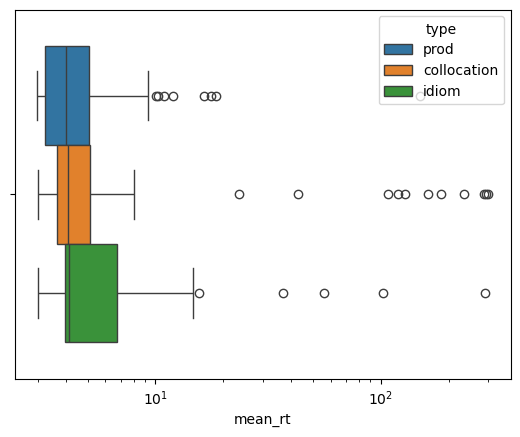

In [108]:
plot = sns.boxplot(
    agg_results_sbert,
    x="mean_rt",
    hue="type",
    log_scale=True,
    # hue="type_j",
    # kind="kde",
    # fill=True,
    # bw_adjust=0.25,
    # log_scale=(False, True),
    # multiple="stack",
    # log_scale=True,
    # common_norm=False,
    # stat="proportion",
)

In [109]:
agg_results_sbert.groupby("type").agg(
    mean_rt=("mean_rt", "mean"),
    std_rt=("mean_rt", "std"),
)

,mean_rt,std_rt
type,,
collocation,26.551098,66.656089
idiom,10.996260,33.837198
prod,6.871626,16.185941


<Axes: >

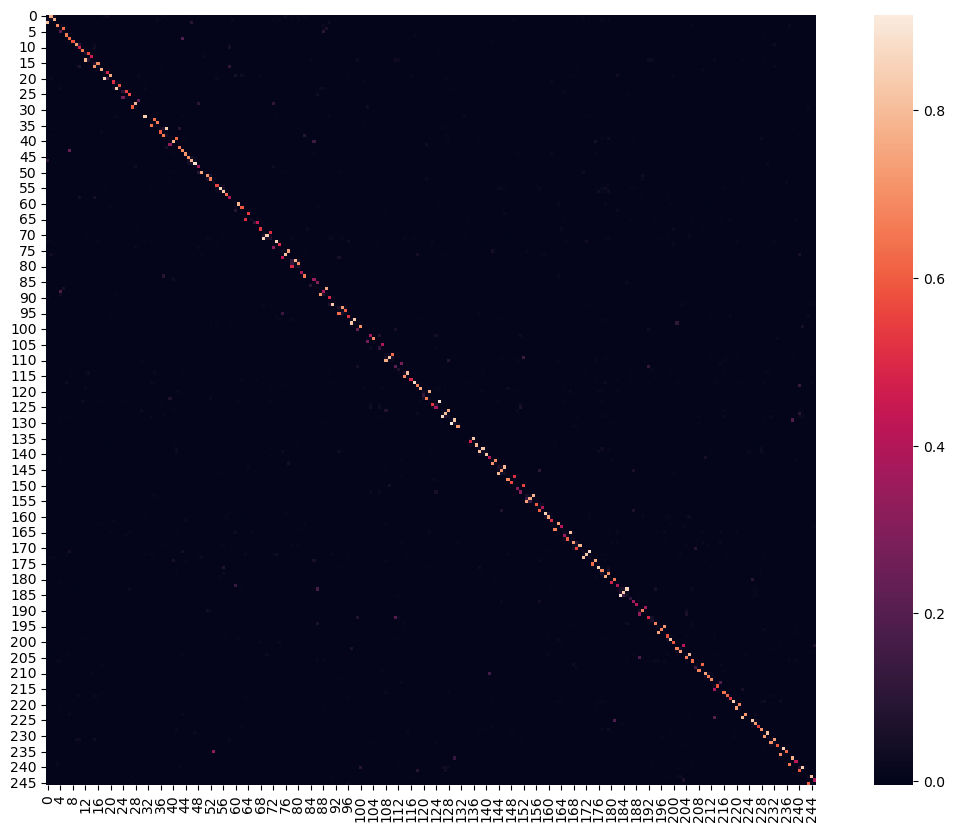

In [110]:
def minerva_activate(probe, Mat, tau=1.0):
    similarity = torch.cosine_similarity(probe, Mat, dim=1)
    activation = torch.abs(similarity**tau) * torch.sign(
        similarity
    )  # make sure we preserve the signs
    # return activation / activation.sum()
    return activation

# matrix0, sampled_items0 = get_minerva_matrix_and_sims(
#     item_embeddings, item_freq, forget_prob=FORGET_PROB, M=10000, seed=0
# )

probe_matrix_sims = torch.stack(
    [minerva_activate(torch.tensor(row["vec"]), sampled_matrix, tau=round(row["mean_rt"])) for row in agg_results_sbert.iloc]
    # [minerva_activate(torch.tensor(row["vec"]), sampled_matrix, tau=1) for row in agg_results.iloc]
)

n_items = df_expanded["item"].nunique()

pairwise_agg_sims, data_df = get_mean_sims(probe_matrix_sims, sampled_items, n_items)
data_df.rename(columns={"mean_sim": "mean_activation"}, inplace=True)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(pairwise_agg_sims, ax=ax, square=True)

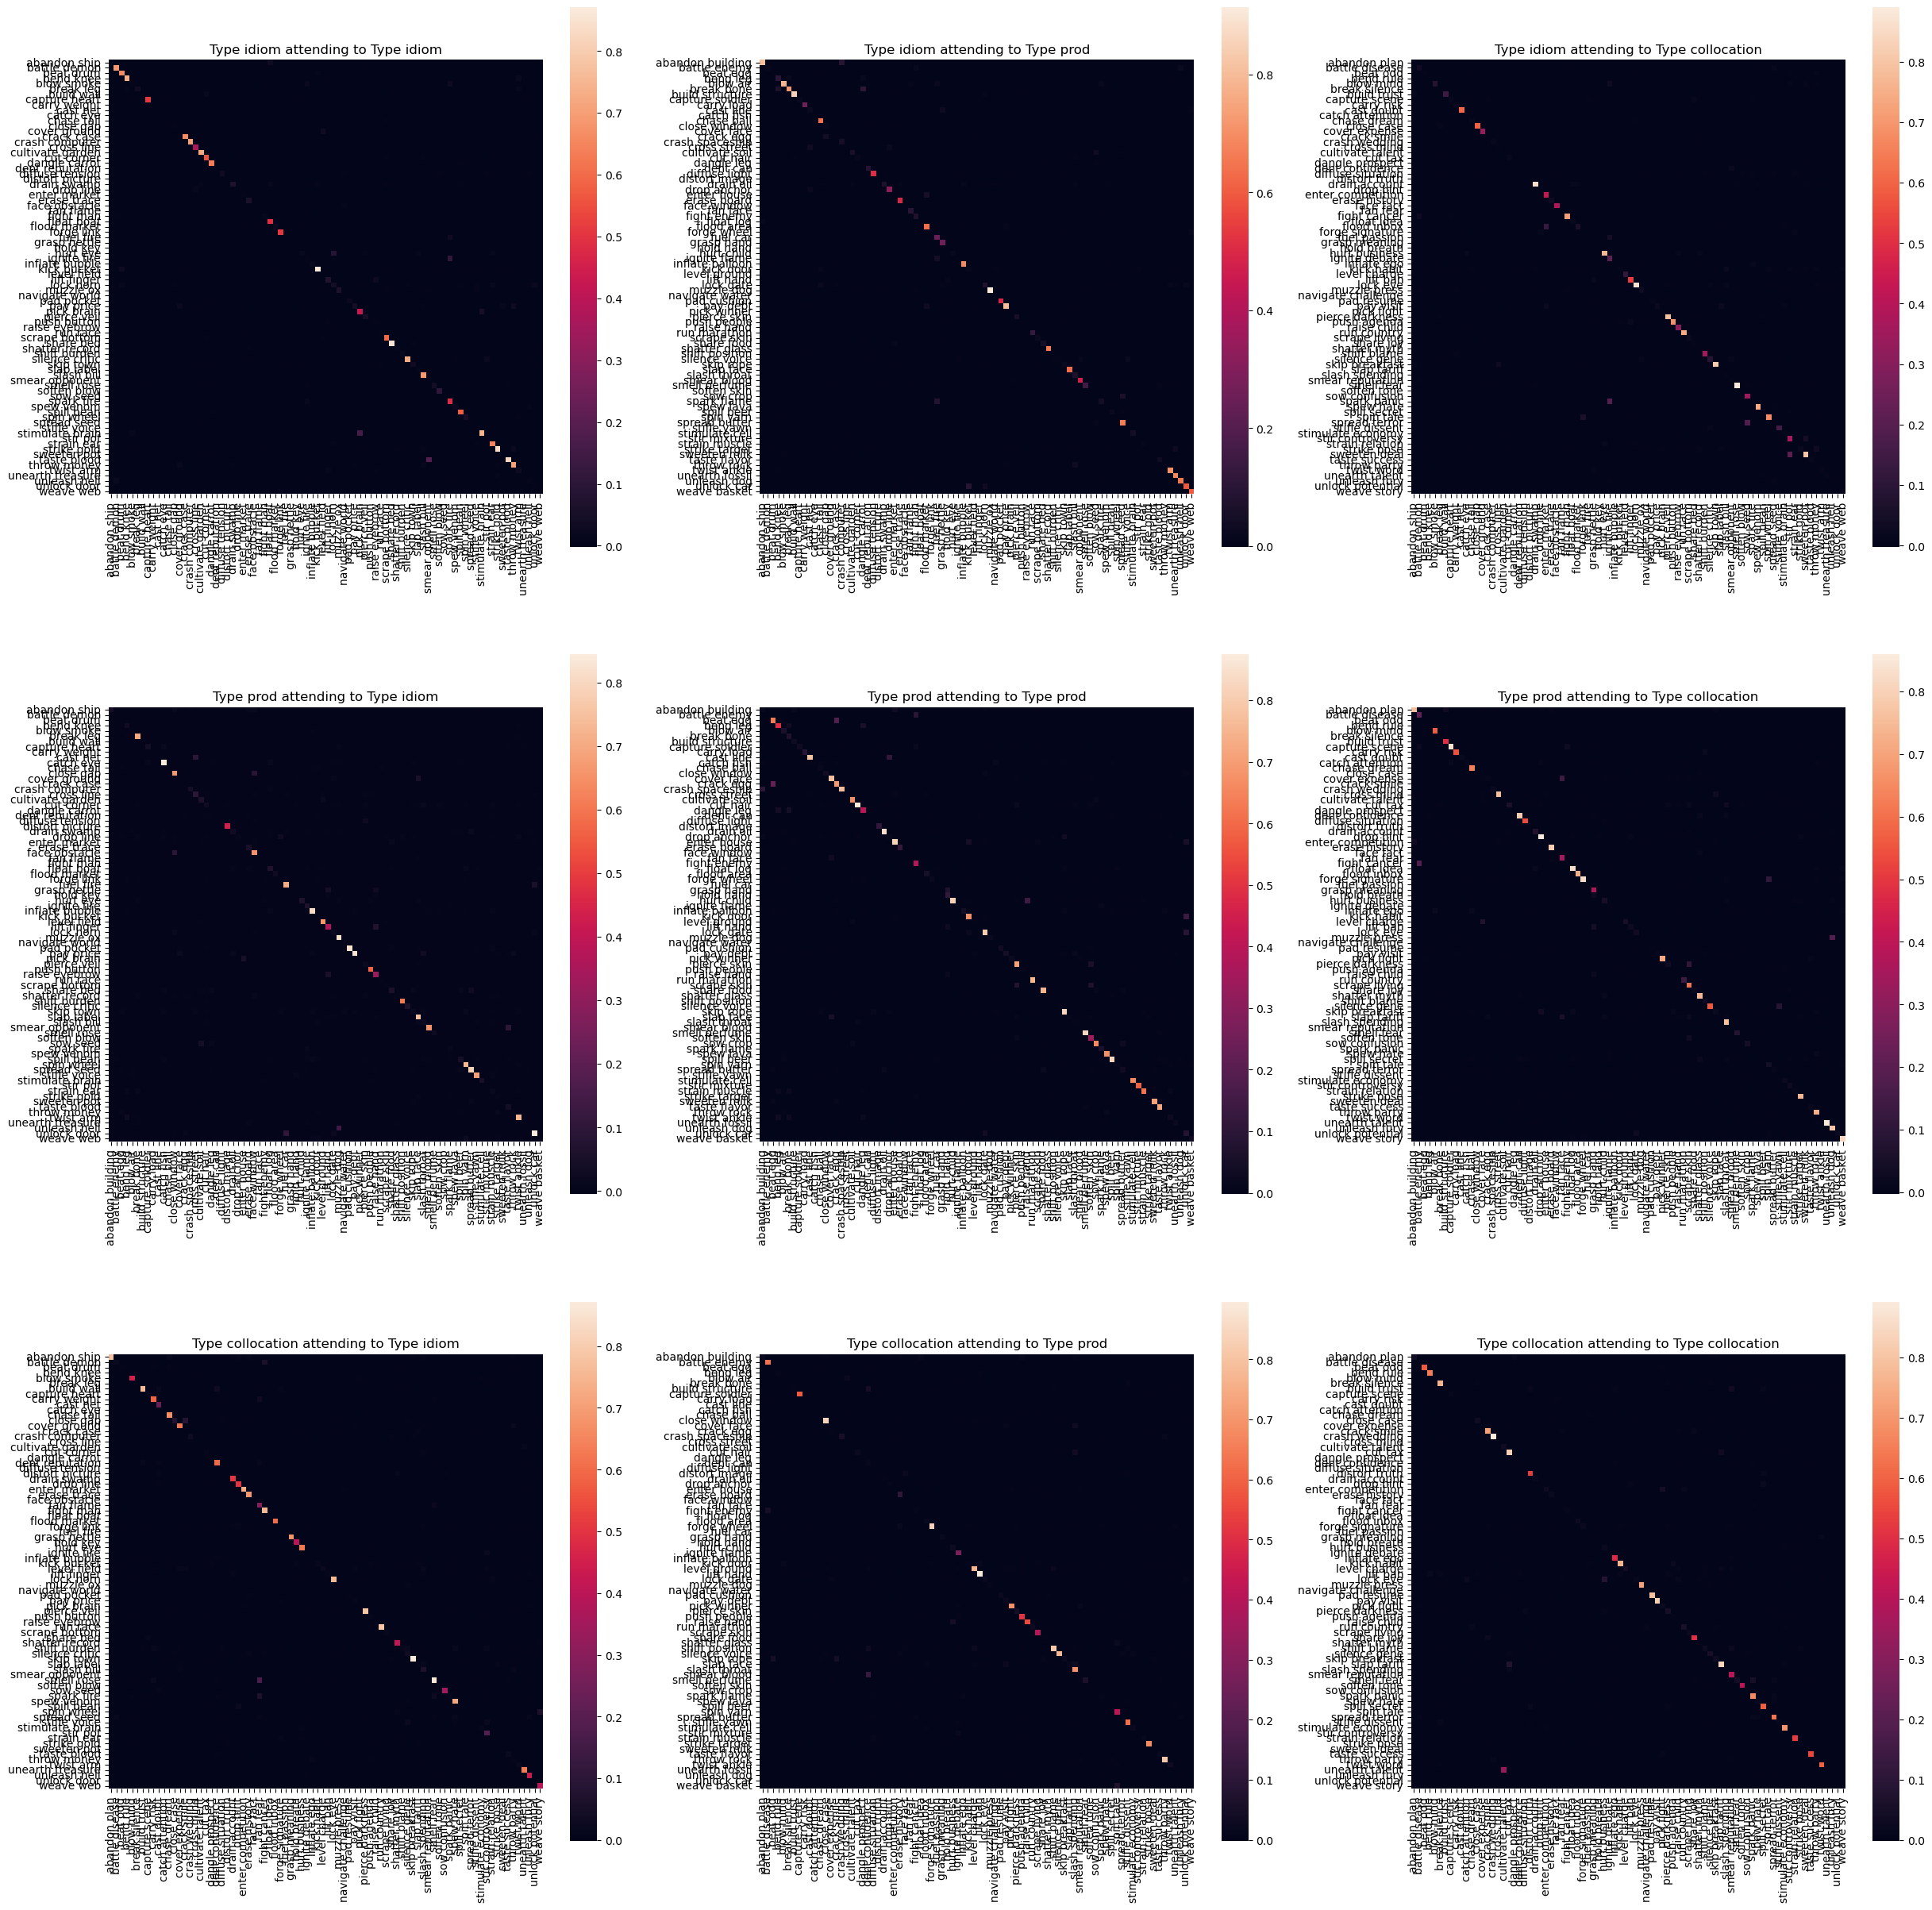

In [111]:
probe_matrix_sims = torch.stack(
    [minerva_activate(torch.tensor(row["vec"]), sampled_matrix, tau=round(row["mean_rt"])) for row in agg_results_sbert.iloc]
    # [minerva_activate(torch.tensor(row["vec"]), sampled_matrix, tau=1) for row in agg_results_sbert.iloc]
)

n_items = df_expanded["item"].nunique()

pairwise_agg_sims, data_df = get_mean_sims(probe_matrix_sims, sampled_items, n_items)

data_df.rename(columns={"mean_sim": "mean_activation"}, inplace=True)

fig, axes = plt.subplots(3, 3, figsize=(30, 30))

for i, type_i in enumerate(df_expanded["type"].unique()):
    for j, type_j in enumerate(df_expanded["type"].unique()):
        ax = axes[i, j]
        type_i_selector = np.where(agg_results_sbert["type"] == type_i)[0]
        type_j_selector = np.where(agg_results_sbert["type"] == type_j)[0]

        pairwise_sims_subset = pairwise_agg_sims[type_i_selector, :][:, type_j_selector]
        xticklabels = agg_results_sbert.iloc[type_i_selector]["item"]
        yticklabels = agg_results_sbert.iloc[type_j_selector]["item"]
        ax.set_title(f"Type {type_i} attending to Type {type_j}")
        sns.heatmap(pairwise_sims_subset, ax=ax, square=True, xticklabels=xticklabels, yticklabels=yticklabels)

In [112]:
data_df.groupby("item_i").apply(lambda x: x.sort_values("mean_activation", ascending=False).head(5)).reset_index(drop=True).to_csv("sbert_top5_activations.csv", index=False)

/var/folders/l6/19zx3k5x4sbd3l0r0xdjx8vh0000gn/T/ipykernel_3390/16874416.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_df.groupby("item_i").apply(lambda x: x.sort_values("mean_activation", ascending=False).head(5)).reset_index(drop=True).to_csv("sbert_top5_activations.csv", index=False)


In [113]:
data_df.sort_values("mean_activation", ascending=False).groupby("item_i").head(5).to_csv("sbert_top5_by_activation.csv", index=False)

Text(0.5, 0.98, 'Item activations at mean final tau (attention of item i to item j), by item type')

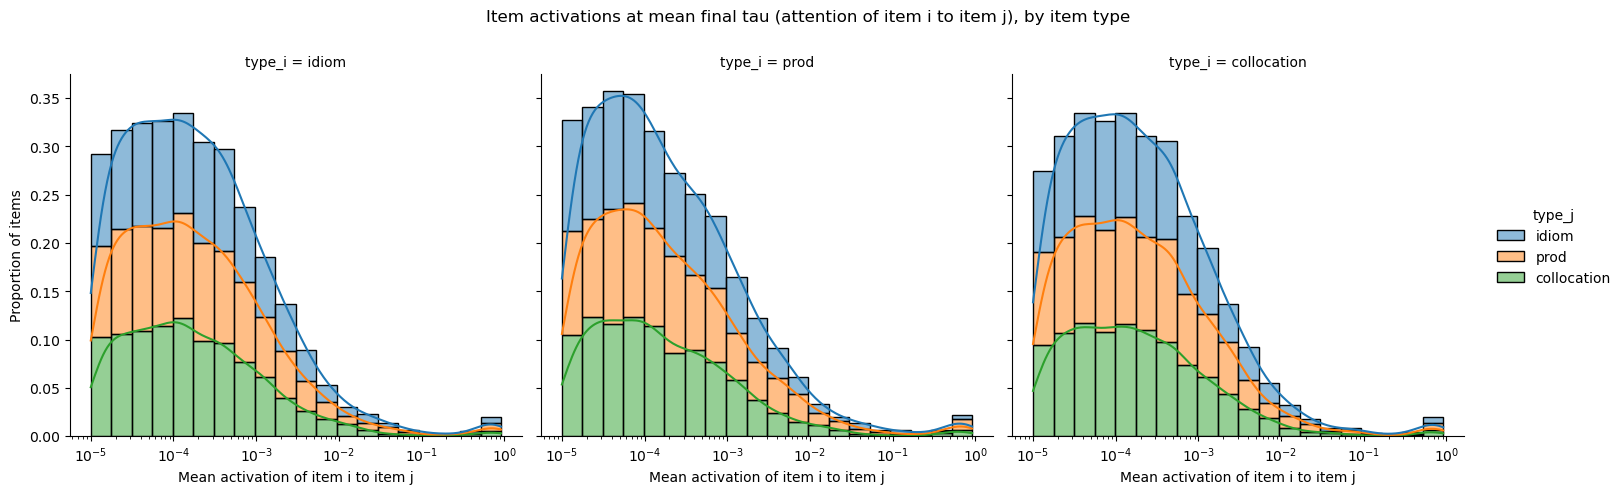

In [114]:
# fig, ax = plt.subplots(figsize=(10,5))
# ax.set_title("Mean similarity of activations, by item type")
plot = sns.displot(
    data_df[abs(data_df["mean_activation"]) > 1e-5],
    x="mean_activation",
    col="type_i",
    hue="type_j",
    bins=20,
    kde=True,
    # kind="kde",
    # fill=True,
    # bw_adjust=0.25,
    # log_scale=(False, True),
    multiple="stack",
    log_scale=True,
    common_norm=False,
    stat="proportion",
)
plot.set(xlabel="Mean activation of item i to item j", ylabel="Proportion of items")
plot.figure.subplots_adjust(top=.85)
plot.figure.suptitle("Item activations at mean final tau (attention of item i to item j), by item type")
# plt.title("Mean similarity of activations, by item type")
# plt.xlabel("Mean similarity of activations")

/var/folders/l6/19zx3k5x4sbd3l0r0xdjx8vh0000gn/T/ipykernel_3390/188644788.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_df_grouped = data_df.groupby("item_i").apply(lambda x: x.nlargest(TOP_N, "mean_activation")).reset_index(drop=True)


Text(0.5, 0.98, 'Item activations of top 3 items at mean final tau (attention of item i to item j), by item type')

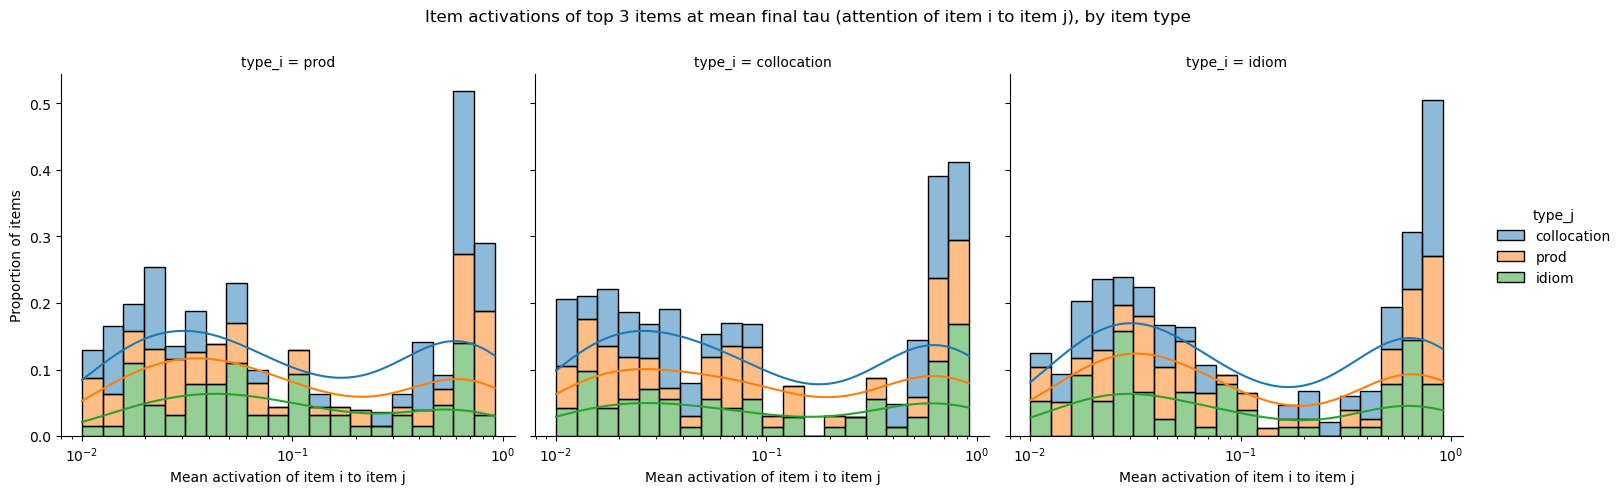

In [115]:
# group data_df by item_i and keep only the top 10 item_j
TOP_N = 3
data_df_grouped = data_df.groupby("item_i").apply(lambda x: x.nlargest(TOP_N, "mean_activation")).reset_index(drop=True)
plot = sns.displot(
    data_df_grouped[data_df_grouped["mean_activation"] > 0.01],
    x="mean_activation",
    col="type_i",
    hue="type_j",
    # kind="kde",
    # fill=True,
    # bw_adjust=0.25,
    # log_scale=(False, True),
    multiple="stack",
    kde=True,
    bins=20,
    log_scale=True,
    common_norm=False,
    stat="proportion",
)
plot.set(xlabel="Mean activation of item i to item j", ylabel="Proportion of items")
plot.figure.subplots_adjust(top=.85)
plot.figure.suptitle(f"Item activations of top {TOP_N} items at mean final tau (attention of item i to item j), by item type")


In [116]:
data_df.groupby("item_i").apply(lambda x: x.nlargest(3, "mean_activation")).reset_index(drop=True).to_csv("tmp.csv")

/var/folders/l6/19zx3k5x4sbd3l0r0xdjx8vh0000gn/T/ipykernel_3390/1848195402.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_df.groupby("item_i").apply(lambda x: x.nlargest(3, "mean_activation")).reset_index(drop=True).to_csv("tmp.csv")


In [117]:
data_df[(data_df["item_i"] == "abandon building") & (data_df["item_j"] == "abandon building")]

,item_i,type_i,item_j,type_j,mean_activation
247,abandon building,prod,abandon building,prod,0.041903


In [118]:
# violin plots
sns.violinplot(
    data=data_df[abs(data_df["mean_sim"]) > 0.01],
    x="type_i",
    y="mean_sim",
    hue="type_j",
    inner="quart",
    linewidth=1,
)

KeyError: 'mean_sim'

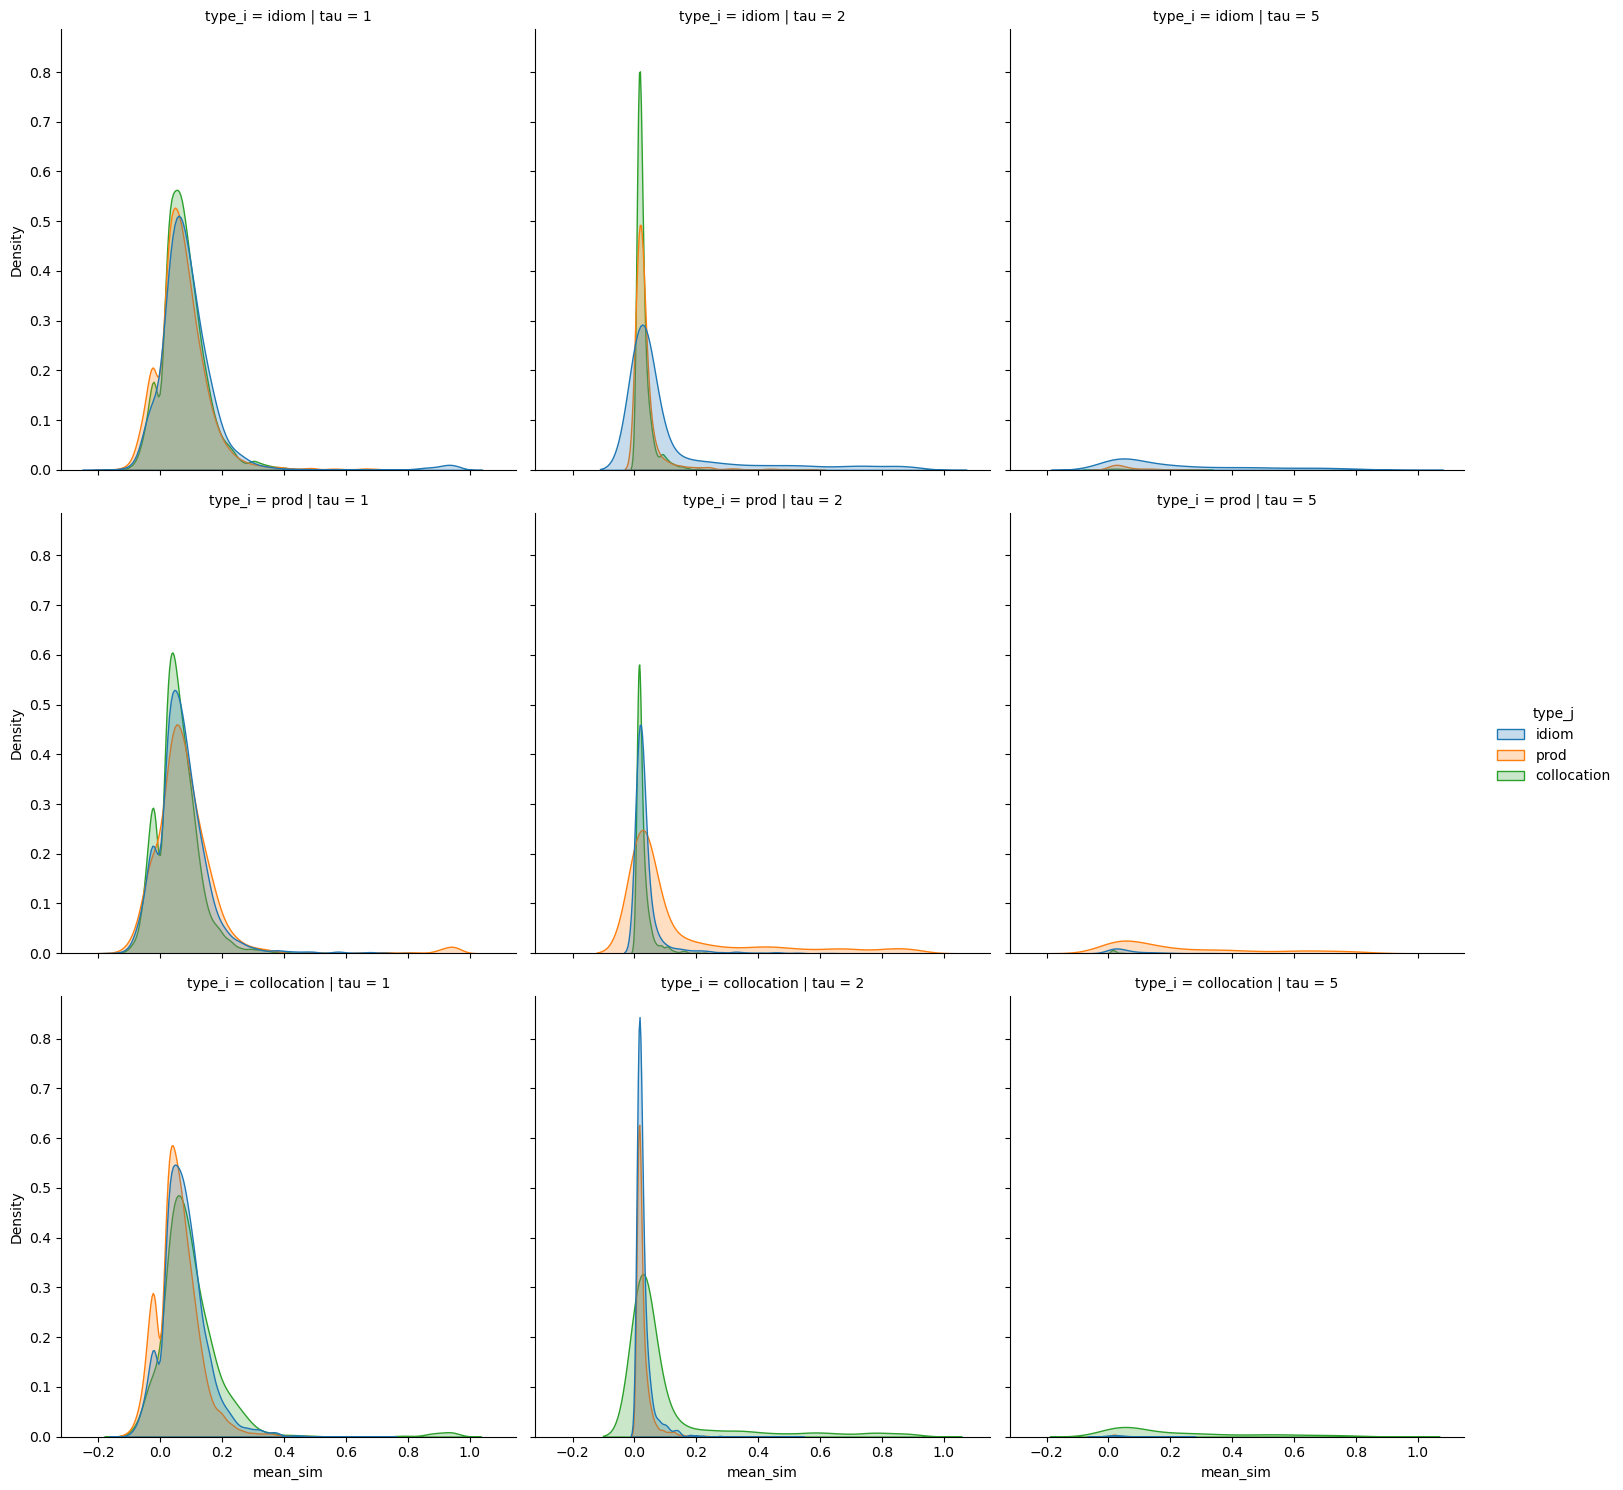

In [ ]:
_simstau1 = df_agg_sims.copy()
_simstau1["tau"] = 1

_simstau2 = _sims.copy()
_simstau2["tau"] = 2
_simstau2["mean_sim"] = _sims["mean_sim"] ** 2

_simstau5 = _sims.copy()
_simstau5["tau"] = 5
_simstau5["mean_sim"] = _sims["mean_sim"] ** 5

_sims = pd.concat([_simstau1, _simstau2, _simstau5])

# _sims["mean_sim_tau2"] = _sims["mean_sim"] ** 2
# _sims = _sims[abs(_sims["mean_sim_tau2"]) > 0.01]
# _sims["mean_sim_tau5"] = _sims["mean_sim"] ** 5
# _sims = _sims[abs(_sims["mean_sim_tau5"]) > 0.01]
# _sims["mean_sim_tau10"] = _sims["mean_sim"] ** 5
# _sims = _sims[abs(_sims["mean_sim_tau5"]) > 0.01]

# _sims["mean_sim"] = _sims["mean_sim"]
sns.displot(
    _sims[abs(_sims["mean_sim"]) > 0.01],
    x="mean_sim",
    row="type_i",
    col="tau",
    hue="type_j",
    kind="kde",
    fill=True,
    # bw_adjust=0.25,
    # log_scale=(False, True),
)

In [ ]:
# typewise agg sims

# get the type of each item
item_types = df_expanded["type"].unique()
n_per_type = df_expanded["type"].value_counts()[item_types[0]]

type_agg_sims = torch.zeros(len(item_types), len(item_types), n_per_type)

for i, t1 in enumerate(item_types):
    for j, t2 in enumerate(item_types):
        where_t1 = df_expanded["type"] == t1
        where_t2 = df_expanded["type"] == t2
        type_agg_sims[i, j] = pairwise_agg_sims[where_t1][:, where_t2].mean(dim=0)

type_agg_sims.shape

# sns.heatmap(pairwise_agg_sims, xticklabels=item_types, yticklabels=item_types)

torch.Size([3, 3, 82])